In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD, AdamW
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
import numpy as np
from dataclasses import dataclass

from transformers.train import Trainer 
from transformers.utils import get_device, num_params
from transformers.vision.data import CIFARDataLoader
from transformers.vision.base_model import BadNet, VisionModel
from transformers.vision.vgg import VGG16 
from transformers.vision.resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152

# reload imported modules automatically (so you dont have to restart kernel when changing .py files)
%load_ext autoreload
%autoreload 2

device = get_device()
print(f"using device: {device}")

using device: mps


{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
45000 5000 10000
352 40
torch.Size([128, 3, 32, 32]) torch.Size([128])


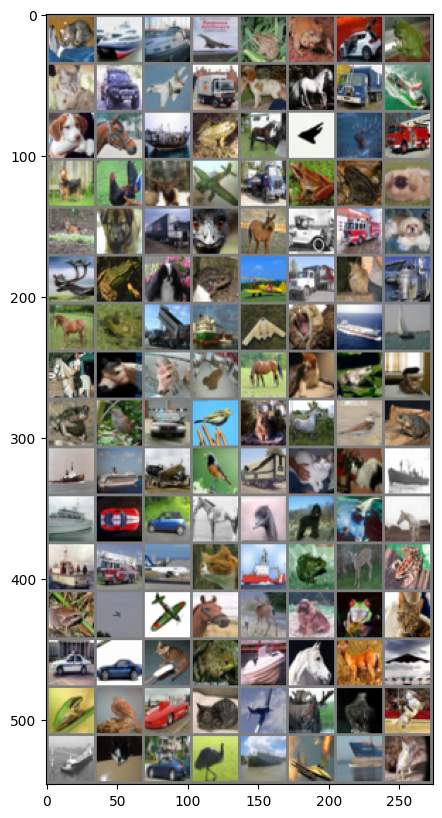

{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean 0.5, std 0.5 for each channel
]) 

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean 0.5, std 0.5 for each channel
]) 

trainset_full = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
trainset, valset = random_split(trainset_full, [0.9, 0.1])

trainloader = CIFARDataLoader(trainset, batch_size=128, shuffle=True)
valloader = CIFARDataLoader(valset, batch_size=128, shuffle=False)
testloader = CIFARDataLoader(testset, batch_size=128, shuffle=False)

class_to_idx = trainset_full.class_to_idx # type: ignore
idx_to_class = {v: k for k, v in class_to_idx.items()}

def imshow(img: torch.Tensor):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_label_counts_from_dataset(dataset_obj: Dataset):
    label_counts = {}
    
    if isinstance(dataset_obj, torch.utils.data.Subset):
        targets = np.array(dataset_obj.dataset.targets) # type: ignore
    elif hasattr(dataset_obj, 'targets'):
        targets = np.array(dataset_obj.targets) # type: ignore
    else:
        targets = [label for _, label in dataset_obj]

    unique, counts = np.unique(targets, return_counts=True)
    for label, count in zip(unique, counts):
        label_counts[idx_to_class[int(label)]] = int(count)
    return label_counts

print(idx_to_class)
print(len(trainset), len(valset), len(testset))
print(len(trainloader), len(valloader))

batch = next(iter(testloader))
x, y = batch.x, batch.y
print(x.shape, y.shape)
imshow(make_grid(x))

train_counts = get_label_counts_from_dataset(trainset)
test_counts = get_label_counts_from_dataset(testset)
print(train_counts)
print(test_counts)

In [8]:
model = ResNet34(10)
model = model.to(device, memory_format=torch.channels_last) # type: ignore
print(num_params(model))
# acc, f1 = model.full_eval(test_loader=testloader)

print(model)

batch = next(iter(trainloader))
batch = batch.to(device)
model(batch.x).shape

21294026
ResNet34(
  (blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): _ResidualBlock(
        (shortcut_proj): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (blocks): ModuleList(
          (0-2): 3 x Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): 

torch.Size([128, 10])

In [14]:
def metrics(model: VisionModel):
    acc, f1 = model.full_eval(valloader, device, idx_to_class, plot=False)
    return {"accuracy": float(acc), "f1": float(f1)}

trainer = Trainer(
    model=model, 
    train_loader=trainloader, # type: ignore
    val_loader=valloader, # type: ignore
    device=device,
    max_lr=1e-3,
    min_lr=5e-5,
    weight_decay=1e-2,
    n_epochs=25, 
    log_steps=50,
    eval_steps=250, 
    save_steps=500,
    use_mixed_precision=False,
    compute_metrics=metrics, # type: ignore ,
    max_epochs_without_improvement=5,
    checkpoint_dir="checkpoints/cifar10-resnet34" 
)

# trainer.optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

trainer.load_checkpoint("checkpoints/cifar10-resnet34")
# model = trainer.model

val_loss = trainer.eval()
trainer.train()

Evaluating: 100%|██████████| 40/40 [00:01<00:00, 30.86it/s]


step:   1500 (4.26 epochs) | train loss: 0.4914 | lr: 9.34e-04 | steps/s:  7.5 (0.78 mins/epoch)
EVAL:   1500 | val loss: 0.6286 | eval time: 2.52s|  {'accuracy': 0.7844, 'f1': 0.7858805945167278}
not saving because last val loss is higher than best checkpoint (0.6286 > 0.6205)(1.42 / 5.00 epochs without improvement)
step:   1550 (4.40 epochs) | train loss: 0.5024 | lr: 9.29e-04 | steps/s:  7.3 (0.80 mins/epoch)
step:   1600 (4.55 epochs) | train loss: 0.4994 | lr: 9.25e-04 | steps/s:  7.6 (0.77 mins/epoch)
step:   1650 (4.69 epochs) | train loss: 0.4771 | lr: 9.20e-04 | steps/s:  7.6 (0.77 mins/epoch)
step:   1700 (4.83 epochs) | train loss: 0.5184 | lr: 9.15e-04 | steps/s:  7.6 (0.77 mins/epoch)
step:   1750 (4.97 epochs) | train loss: 0.5097 | lr: 9.10e-04 | steps/s:  7.6 (0.77 mins/epoch)
EVAL:   1750 | val loss: 0.6112 | eval time: 2.84s|  {'accuracy': 0.7912, 'f1': 0.7896843011550897}
step:   1800 (5.11 epochs) | train loss: 0.4932 | lr: 9.05e-04 | steps/s:  7.0 (0.83 mins/epoch)

KeyboardInterrupt: 

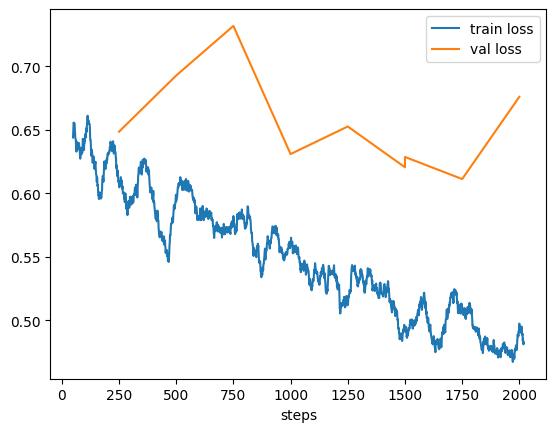

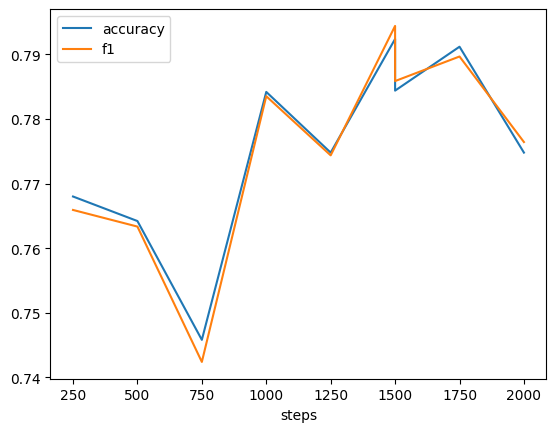

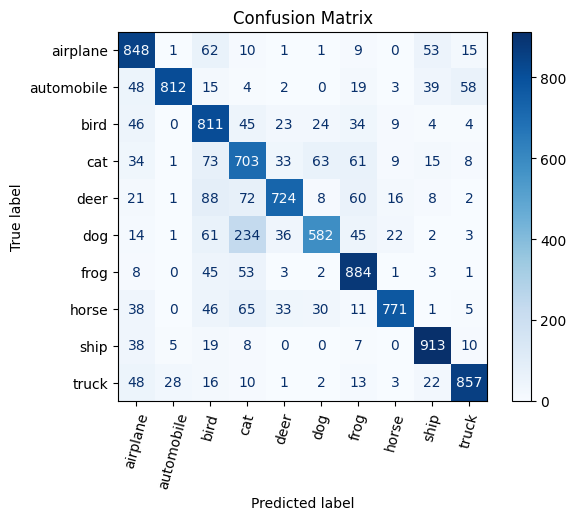

Accuracy: 79.05%
F1 Score (macro): 79.18


(np.float64(0.7905), 0.7918496940588163)

In [15]:
trainer.plot(train_loss_smoothing=None, plot_metrics=True)
model.full_eval(testloader, device=device, idx_to_class=idx_to_class) # type: ignore

In [ ]:
{**trainloader.__dict__, "batch_size": 1}